# Variational Autoencoder
- refers to variational inference
- extension of expectation-maximization
- output of encoder is a guassian, output of decoder is a bernoulli
- then turn output to bayesian --> p(x_reconstructed | x ~ bernoulli(p)) 
- then generate samples from that distribution

#### Parameterize a gaussian
- https://sefiks.com/2017/08/11/softplus-as-a-neural-networks-activation-function/
- approximates p(z|x), the true conditional distribution, as q(z|x)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

In [3]:
def softplus(x):
    # automatically adds 1 
    return np.log1p(np.exp(x))

In [5]:
def forward(x, W1, W2):
    hidden = np.tanh(x.dot(W1))
    output = hidden.dot(W2) # no activation
    mean   = output[:2]
    std    = softplus(output[2:])
    return mean, std

Make a random input and generate some samples

In [15]:
input_ = 4
hidden = 3
output = 2
W1 = np.random.randn(input_, hidden)
# multiply by 2 for mean and std (2 params!)
W2 = np.random.randn(hidden, output*2)

x = np.random.randn(input_)

mean, std = forward(x, W1, W2)
print("mean: {}, std: {}".format(mean, std))

samples = mvn.rvs(mean=mean, cov=std**2, size=10000)

mean: [0.33638964 0.20765664], std: [1.18091054 0.37806086]


plot the samples

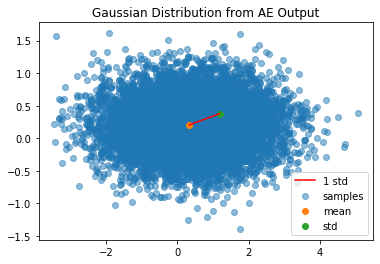

In [29]:
plt.scatter(samples[:,0], samples[:,1], alpha=.5, label='samples')
plt.scatter(mean[0], mean[1], label='mean')
plt.scatter(std[0], std[1], label='std')
plt.plot([mean[0], std[0]], [mean[1], std[1]], 'r', label='1 std')
plt.legend()
plt.title("Gaussian Distribution from AE Output")
plt.show()